# Variational Autoencoders: the Basics

Variation autoencoders (VAEs) are an extended type of autoencoders (AEs). A VAE can enhance the robustness of content generation by regularising the encodings distribution in the latent space. In this notebook, we will go through the fundamentals of VAEs (motivation, theory and Keras-based implementation) using the `mnist-digits` dataset. We will also learn two useful extensions of VAEs: the disentangled VAEs ($\beta$-VAEs) and the conditional VAEs. 

This notebook involves the minimal math to understand the VAEs. Check [06_VAE_theory.ipynb](06_VAE_theory.ipynb) for a more detailed theory. 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# need certainty to explain some of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.3.0


---

# The Dataset

In this notebook, we will use the `mnist-digits` dataset. It is simpler than the `mnist-fashion` dataset, allowing us to use only two features in the latent space so that we can conveniently visualise and examine the encodings distribution in the latent space.

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0].shape))
print("Number of classes: %d" % (np.max(train_labels) + 1))

Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of classes: 10


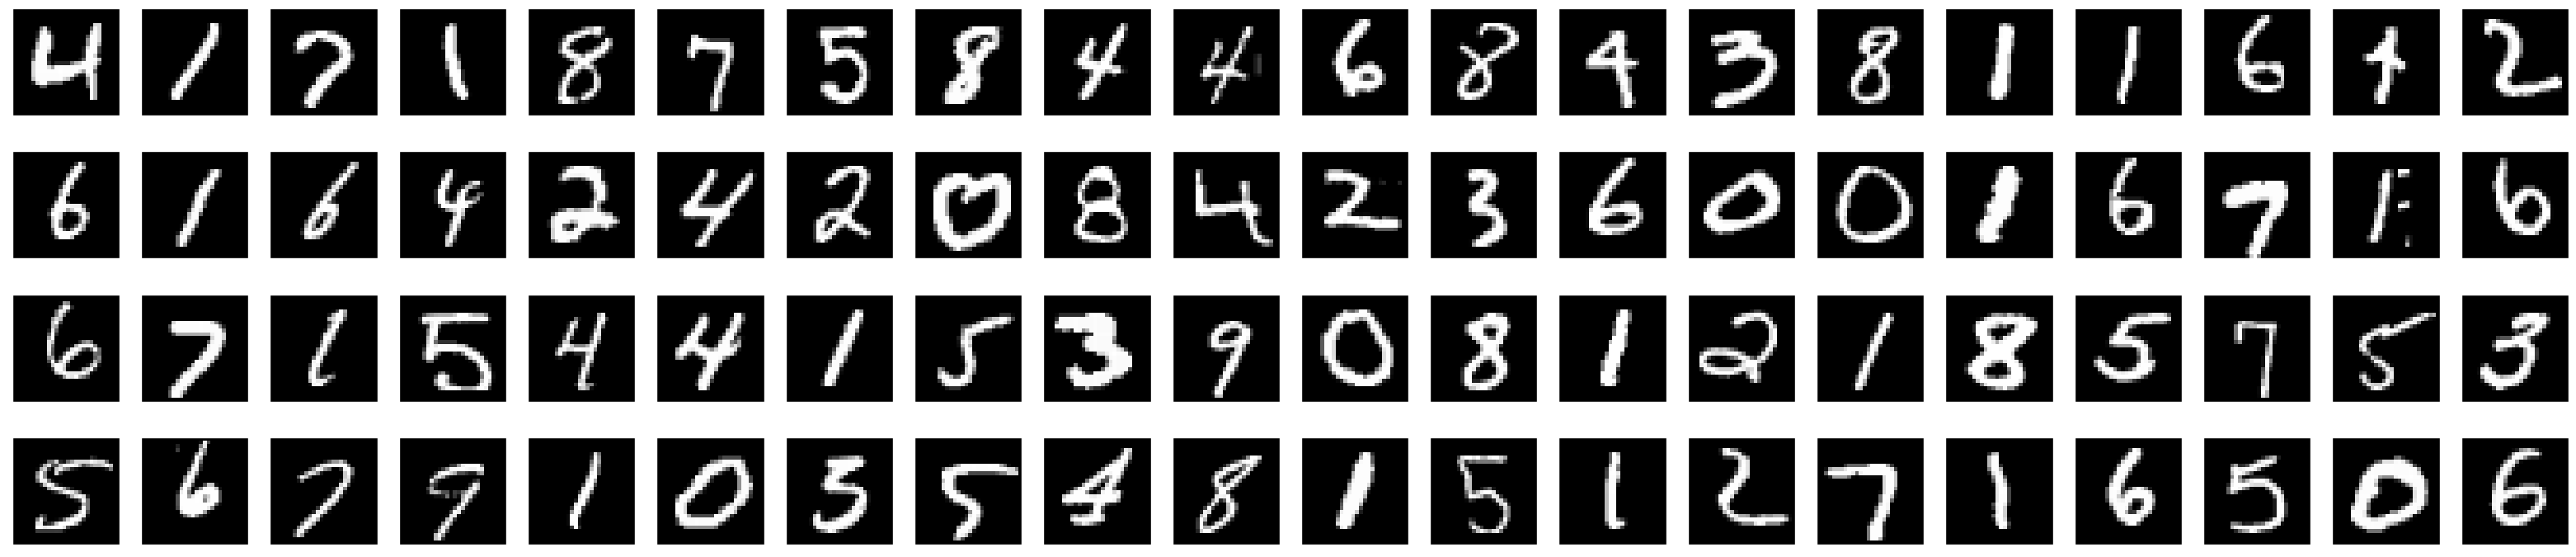

In [3]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images
nrows = 4
ncols = 20
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    subplot_image(1 - train_images[idata], '', nrows, ncols, iplot)
plt.show()

---

# Autoencoders and Regularity of Latent Space

Why we need a VAE? To answer this question, let us start with an ordinary AE and see what is unsatisfactory when we use it to generate new images. 

## 1. Build and train an autoencoder

Based on what we have learnt in [05_autoencoder_basics.ipynb](05_autoencoder_basics.ipynb), we can quickly build an AE with `Dense` layers. First, we specify the latent dimension or the size of the bottleneck; for `mnist-digits`, we can use 2.

In [4]:
# latent dimension
latent_dim = 2

### The encoder

The encoder contains four layers, an input layer with size 28$\times$28, two hidden layers with sizes 128 and 16, respectively, and the latent output layer:

In [5]:
# build the encoder
image_input = keras.Input(shape=(28, 28))
x = layers.Flatten()(image_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(16, activation="relu")(x)
latent_output = layers.Dense(latent_dim)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 102,578
Trainable params: 102,578
Non-trainable params: 0
_________________________________________________________________


### The decoder

The decoder also contains four layers, reciprocal to those of the encoders:

In [6]:
# build the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_input)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
image_output = layers.Reshape((28, 28))(x)
decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 103,360
Trainable params: 103,360
Non-trainable params: 0
_________________________________________________________________


### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

In [7]:
# build the AE
image_input = keras.Input(shape=(28, 28))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
functional_1 (Functional)    (None, 2)                 102578    
_________________________________________________________________
functional_3 (Functional)    (None, 28, 28)            103360    
Total params: 205,938
Trainable params: 205,938
Non-trainable params: 0
_________________________________________________________________


### Train the autoencoder

Now we can train our AE with the `mnist-digits` dataset:

In [8]:
# train the AE
ae_model.fit(train_images, train_images, epochs=50, batch_size=128, 
             validation_data=(test_images, test_images))

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2541 - accuracy: 0.0990 - val_loss: 0.2206 - val_accuracy: 0.1119
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2135 - accuracy: 0.1244 - val_loss: 0.2069 - val_accuracy: 0.1343
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2030 - accuracy: 0.1411 - val_loss: 0.1995 - val_accuracy: 0.1481
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1972 - accuracy: 0.1514 - val_loss: 0.1951 - val_accuracy: 0.1510
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1933 - accuracy: 0.1573 - val_loss: 0.1917 - val_accuracy: 0.1577
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1905 - accuracy: 0.1605 - val_loss: 0.1895 - val_accuracy: 0.1601
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1885 - accuracy: 0.1631 - val_loss: 0.1876 - val_accuracy: 0.1650
Epoch 

## 2. Inspect the latent space

Let us inspect how the images are distributed in the latent space. 

### Encode images

First, we encode the images by our AE. After that, each image becomes a 2D point (because `latent_dim=2`) in the latent space. 

In [9]:
# encode images by AE
train_encodings_AE = encoder_AE.predict(train_images)

### Scatter plot
We can plot the points in the latent space and colour them by their true labels:

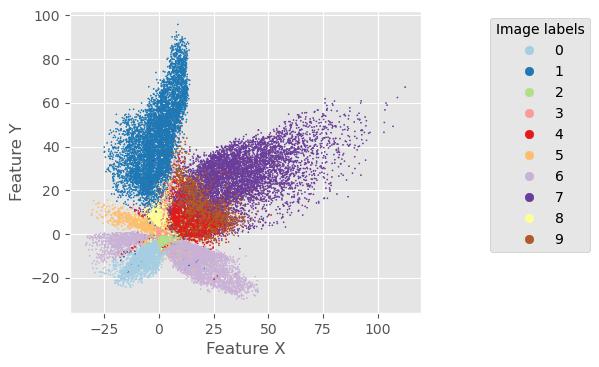

In [10]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=.5, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Image labels', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.gca().set_aspect(1)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_AE, train_labels)

###  Histogram plot

Also, for each digit, we can plot the density histograms of the encodings along the two latent dimensions -- note that we are using the same feature range ($x$-axis) in all the histograms:

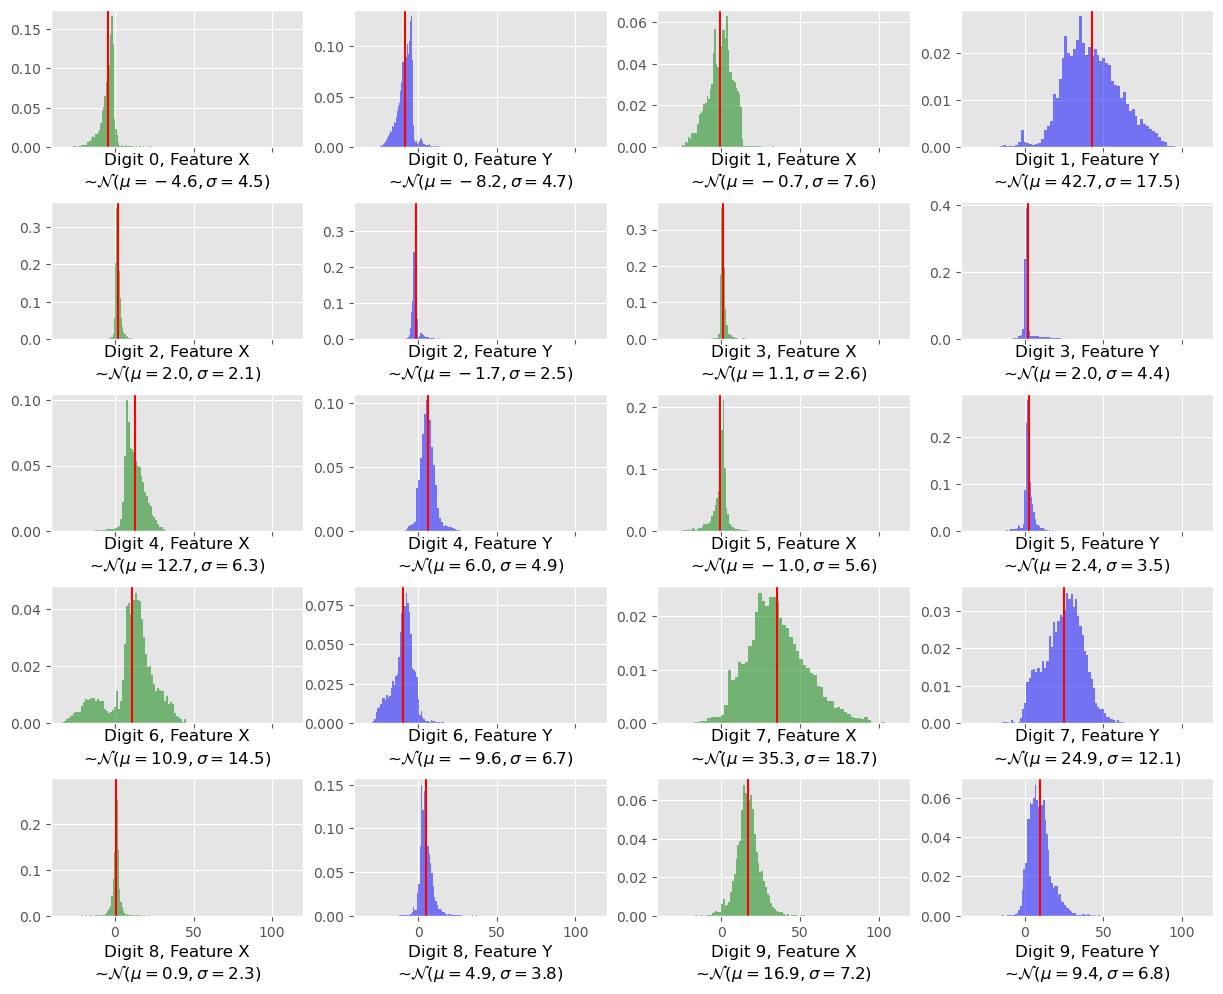

In [11]:
# histogram plot of encodings in the latent space
def hist_plot_encodings_latent(encodings, labels, digit, dim, ax):
    # extract
    encodings_digit = encodings[labels == digit, dim]
    # histogram
    ax.hist(encodings_digit, bins=60, density=True, color=['g', 'b'][dim], alpha=.5)
    # mean and std dev
    mean = np.mean(encodings_digit)
    std = np.std(encodings_digit)
    ax.axvline(mean, c='r')
    ax.set_xlabel('Digit %d, Feature %s\n~${\cal N}(\mu=%.1f, \sigma=%.1f)$' % 
                  (digit, ['X', 'Y'][dim], mean, std), c='k')
    
# histogram plot of encodings by AE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_AE, train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_AE, train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

### Regularity of the latent space

Both the scatter plot and the histogram plots show that the data distributions in the latent space are rather *irregular*. Some of the digits have very wide distributions (such as 1 and 7) and some very narrow distributions (such as 2 and 3). 

Remember that our goal of training this AE is neither dimensionality reduction nor denoising but to generate new images out of the original dataset. Image generation is done by the decoder, taking the latent features (`X` and `Y` in the plots) as the input. An irregular latent space makes image generation less controllable and robust. Taking our case for example, two shortcomings are likely to emerge:

1. **Controllability**: sampling the entire latent space, we will generate much more of the widely distributed digits than the narrowly distributed ones; instead, if we limit the range of the latent space, we will loss some characteristics of the widely distributed ones;

2. **Robustness**: images that do not resemble any of the digits will be generated by the gaps between the distributions of the digits; such gaps increase with the range of the latent space.

## 3. Generate new images

The following function generates new images by uniformly sampling the latent space within a specified range (`[x0, x1]`, `[y0, y1]`). 

In [12]:
# generate images from the latent space
def generate_images_latent(decoder, x0, x1, dx, y0, y1, dy):
    # uniformly sample the latent space
    nx = round((x1 - x0) / dx) + 1
    ny = round((y1 - y0) / dy) + 1
    grid_x = np.linspace(x0, x1, nx)
    grid_y = np.linspace(y1, y0, ny)
    latent = np.array(np.meshgrid(grid_x, grid_y)).reshape(2, nx * ny).T

    # decode images
    decodings = decoder.predict(latent)
    
    # display a (nx, ny) 2D manifold of digits
    figure = np.zeros((28 * ny, 28 * nx))
    for iy in np.arange(ny):
        for ix in np.arange(nx):
            figure[iy * 28 : (iy + 1) * 28, ix * 28 : (ix + 1) * 28] = decodings[iy * nx + ix]
            
    # plot figure
    plt.figure(dpi=100, figsize=(nx / 3, ny / 3))
    plt.xticks(np.arange(28 // 2, nx * 28 + 28 // 2, 28), np.round(grid_x, 1), rotation=90)
    plt.yticks(np.arange(28 // 2, ny * 28 + 28 // 2, 28), np.round(grid_y, 1))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.imshow(figure, cmap="Greys_r")
    plt.grid(False)
    plt.show()

Let us see how the generated images look like. We choose a range of $-25<X<25$ and $-20<Y<30$, which encompasses all the digits and most of the data points. The two shortcomings can be observed:

1. Only a very few instances of the narrowly distributed digits are generated, such as 2 and 3;
2. Many images do not resemble any of the digits; note that the severely rotated digits should be recognised as non-digits in this context.

Feel free to try some other ranges. 

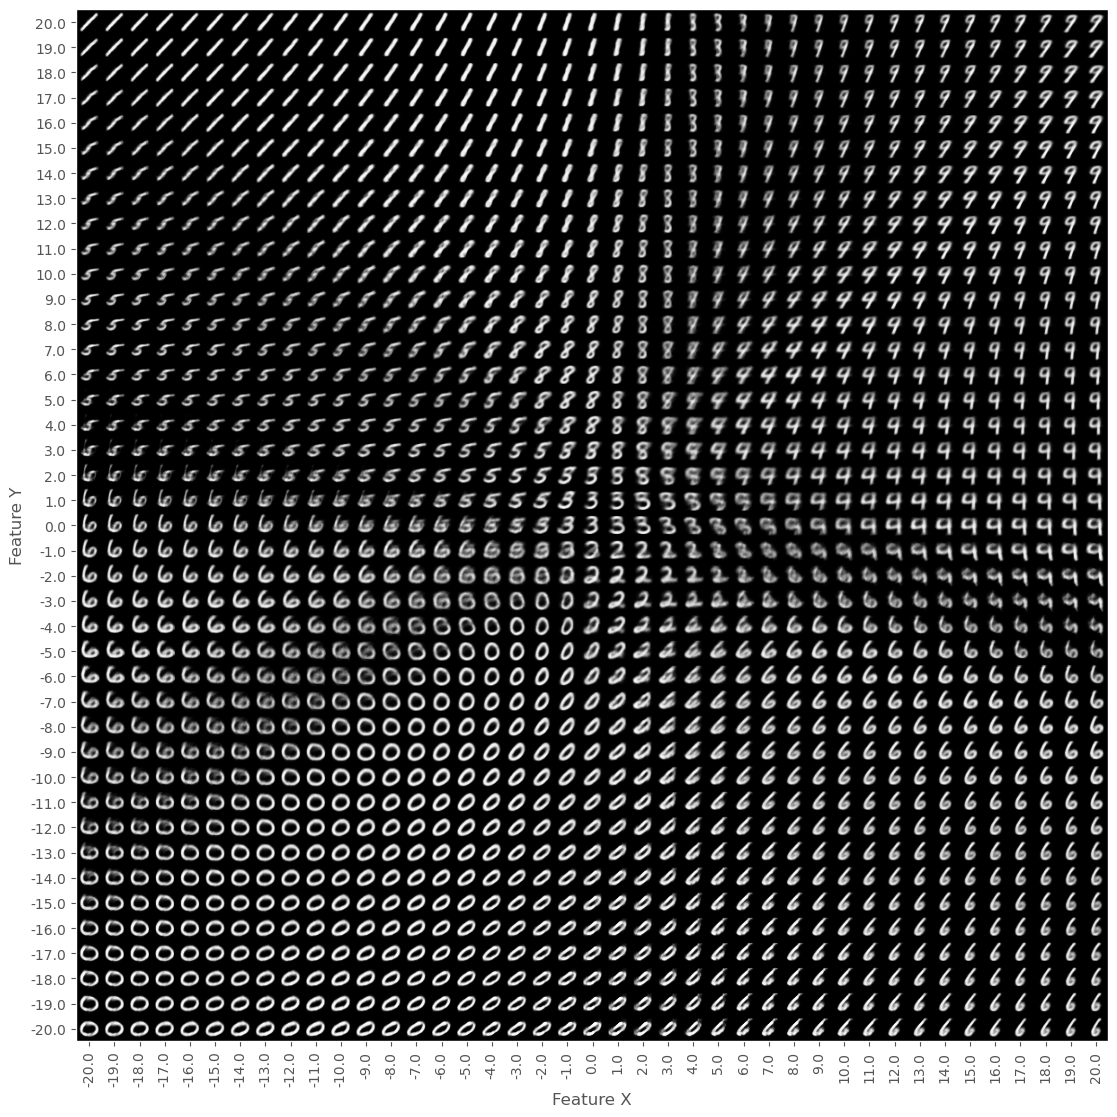

In [13]:
# generate images by AE
generate_images_latent(decoder_AE, x0=-20, x1=20, dx=1, y0=-20, y1=20, dy=1)

---

# Variational Autoencoders

Overfitting is the essential reason behind an irregular latent space of a naive AE, that is, the neural networks for encoding and decoding try their best to fit the data from end to end without caring about how the latent space is organised with respect to the original data. A VAE can regularise the latent space by imposing additional distributional properties on the latent space.

The following figure summarises **the two extensions** from an AE to a VAE:

1. Unlike a naive AE that encodes an input data $x$ as a single point $z$ in the latent space, a VAE encodes it as a normal distribution $\mathcal{N}(\mu, \sigma)$, and the latent feature $z$ is sampled from this distribution and then passed to the decoder;

2. An AE only minimises the reconstruction error $\lVert x-x'\rVert^2$ to fit the data, whereas a VAE minimises the sum of the reconstruction error and the KL divergence (Kullback–Leibler divergence) between the latent distribution $\mathcal{N}(\mu, \sigma)$ and the standard normal distribution $\mathcal{N}(0, 1)$.

How does a VAE regularise the latent space? The loss function provides a straightforward answer: in addition to fitting the data by minimising the reconstruction error, it also drags the latent distribution to a standard normal distribution. The final model is a trade-off between the two effects. Also, because each input image is encoded as a Gaussian blob instead of a single point, the gaps in the latent space can be filled by such blurring so that meaningless decodings can be largely avoided.

![ae-vae.png](https://i.ibb.co/DDTgq7Z/ae-vae.png)



## 1. Build and train a VAE

Now we will implement a VAE for `mnist-digits`. The rigorous theory is more complicated than explained above, which can be found in [06_VAE_theory.ipynb](06_VAE_theory.ipynb). 


### The encoder

To implement the probabilistic encoder, we first need a custom function to sample the latent distribution, as implemented by the `Sampling` class. Note that here we are using $\ln\sigma$ instead of $\sigma$ in the network; otherwise, the implementation will be complicated as we have to impose positiveness on $\sigma$.  

In [14]:
# sampling z with (z_mean, z_log_var)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    
# build the encoder
image_input = keras.Input(shape=(28, 28))
x = layers.Flatten()(image_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_VAE.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          100480      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 16)           2064        dense_6[0][0]                    
_______________________________________________________________________________________

### The decoder

The docoder is the same as that of AE.

In [15]:
# build the decoder
z_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(z_input)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
image_output = layers.Reshape((28, 28))(x)
decoder_VAE = keras.Model(z_input, image_output)
decoder_VAE.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_9 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               101136    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 103,360
Trainable params: 103,360
Non-trainable params: 0
_________________________________________________________________


### The VAE

To add the KL divergence to the loss, we create a class `VAE` derived from `keras.Model` and overwrite its `train_step()` method:

In [16]:
# VAE class
class VAE(keras.Model):
    # constructor
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * 28 * 28
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

Now we can build, compile and train our VAE:

In [17]:
# build the VAE
vae_model = VAE(encoder_VAE, decoder_VAE)

# compile the VAE
vae_model.compile(optimizer=keras.optimizers.Adam())

# train the VAE
vae_model.fit(train_images, train_images, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 209.6730 - reconstruction_loss: 203.2215 - kl_loss: 6.4515
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 169.8699 - reconstruction_loss: 166.8946 - kl_loss: 2.9753
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 164.0676 - reconstruction_loss: 161.0034 - kl_loss: 3.0642
Epoch 4/50
469/469 [==============================] - 2s 3ms/step - loss: 161.1415 - reconstruction_loss: 158.0127 - kl_loss: 3.1288
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 158.6190 - reconstruction_loss: 155.4019 - kl_loss: 3.2171
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 156.4386 - reconstruction_loss: 153.1559 - kl_loss: 3.2827
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 154.7994 - reconstruction_loss: 151.4735 - kl_loss: 3.3259
Epoch 8/50
469/469 [==============================] - 2s 3ms/step - l

## 2. Inspect the latent space

Next, we can inspect the latent space following the same steps we did for the AE. Clearly, the latent distributions become much more regular than before.

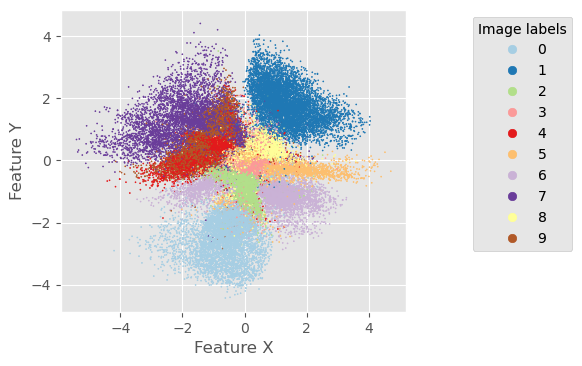

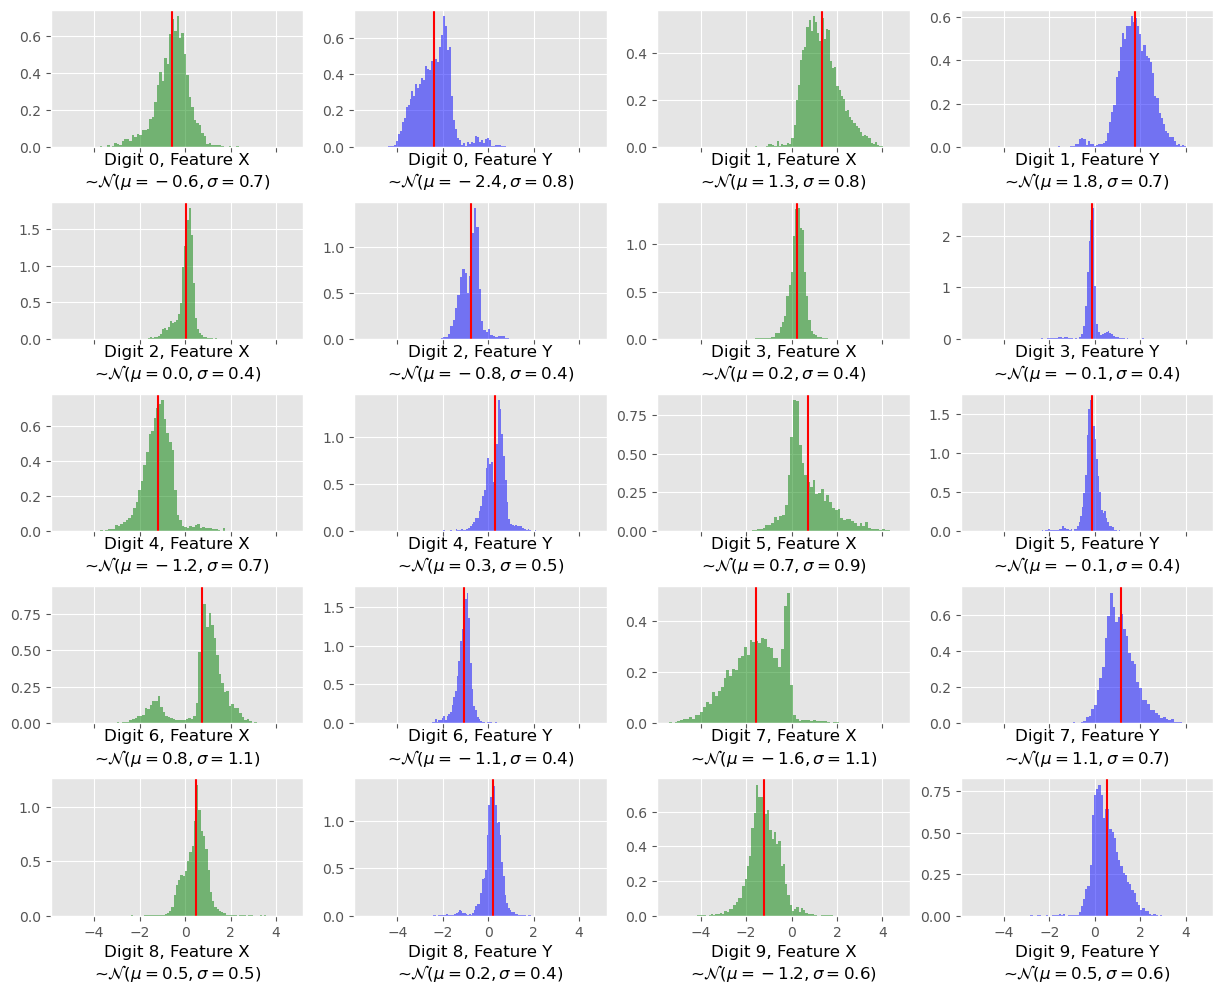

In [18]:
# encode images by VAE
train_encodings_VAE = encoder_VAE.predict(train_images)

# scatter plot of encodings by VAE
scatter_plot_encodings_latent(train_encodings_VAE[2], train_labels)

# histogram plot of encodings by VAE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_VAE[2], train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_VAE[2], train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

## 3. Generate new images

Finally, we can generate new images with our VAE. The result shows that, compared to the AE, the numbers of the generated digits have become more in unison and the number of non-digit images has been greatly reduced.

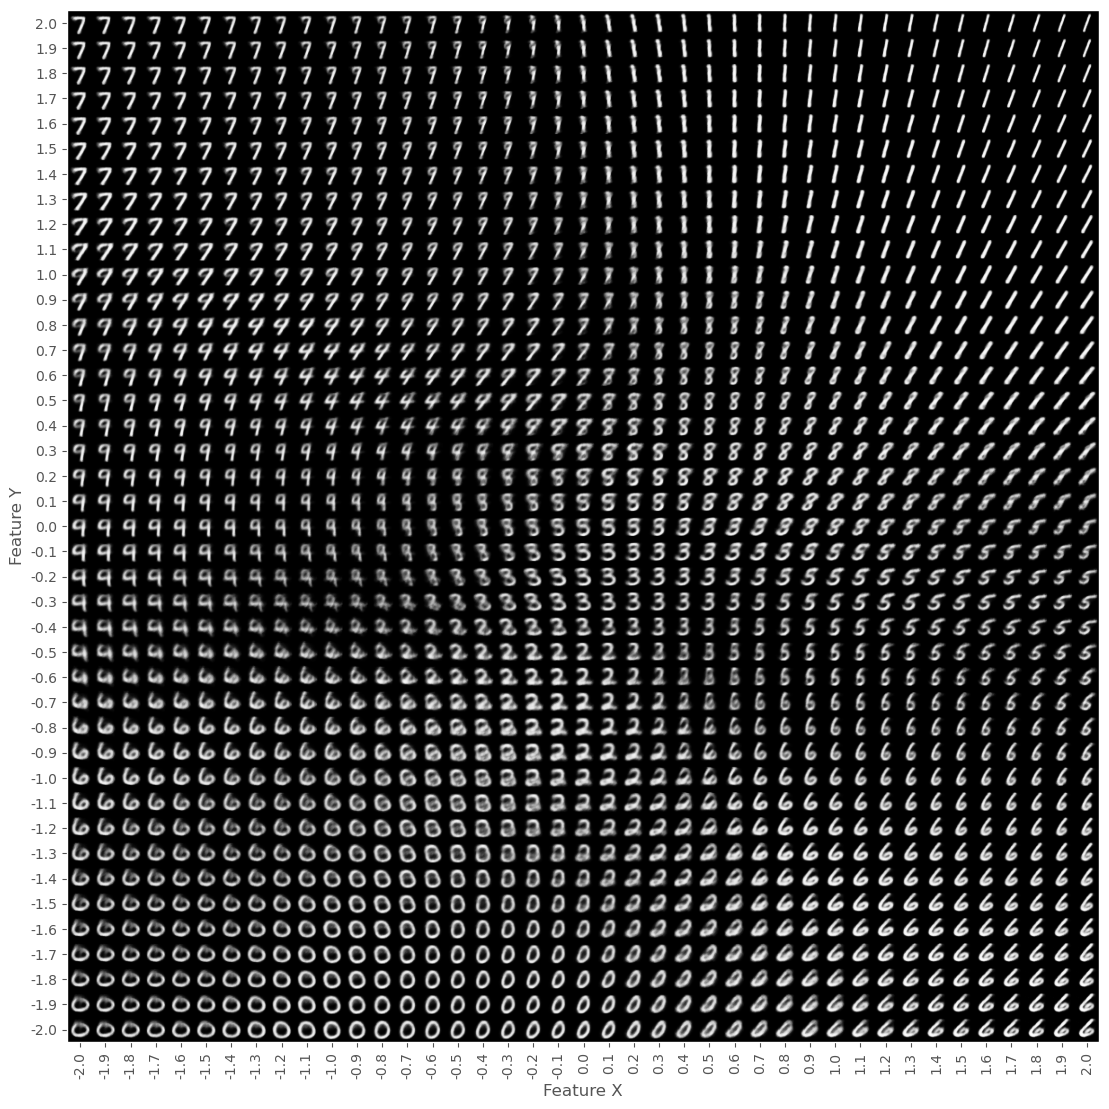

In [19]:
# generate images by VAE
generate_images_latent(decoder_VAE, x0=-2, x1=2, dx=.1, y0=-2, y1=2, dy=.1)

---

# Disentangled Variational Autoencoders

Disentangled VAEs or $\beta$-VAEs are an extended type of VAEs. As explained before, the loss of a VAE consists of two parts, the reconstruction error and the KL divergence: the former tries to fit the network with data and the later to regularise the latent space. It is thus natural to introduce a hyperparameter to weigh these two forces, which gives rise to a disentangled VAE. As you can see in the following cartoon, a factor $\beta$ is applied to the KL divergence, and this $\beta$ is usually greater than 1. In practice, the value of $\beta$ has to be tuned for the best quality of content generation.

So, why we call it "disentangled"? Consider the limit $\beta\rightarrow\infty$: in this case, the distributions of all the latent features will simply converge to $\mathcal{N}(0,1)$, regardless of the data, so they are completely disentangled. In other words, the latent features become increasingly disentangled as $\beta$ increases. 


![bvae.png](https://i.ibb.co/jg2wNpq/bvae.png)

## 1. Implement a $\beta$-VAE

It is straightforward to generalise our VAE implementation: just adding $\beta$ as a hyperparameter to the constructor of the `VAE` class and apply it to the KL divergence in the `train_step()` method. The differences are highlighted in the code.


### The encoder and decoder

They are exactly the same as before.

In [20]:
# build the encoder
image_input = keras.Input(shape=(28, 28))
x = layers.Flatten()(image_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

# build the decoder
z_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(z_input)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
image_output = layers.Reshape((28, 28))(x)
decoder_BVAE = keras.Model(z_input, image_output)

### The $\beta$-VAE

We will use $\beta=10$ for demonstration. Try some other values (particularly a very large value such as 1000) and see what happens.

In [21]:
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * 28 * 28
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

# build the BVAE
########################################
######## NEW: pass beta to BVAE ########
########################################
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=10.)

# compile the BVAE
bvae_model.compile(optimizer=keras.optimizers.Adam())

# train the BVAE
bvae_model.fit(train_images, train_images, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 224.5442 - reconstruction_loss: 215.0064 - kl_loss: 0.9538
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 188.5440 - reconstruction_loss: 178.4062 - kl_loss: 1.0138
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 184.0549 - reconstruction_loss: 172.0228 - kl_loss: 1.2032
Epoch 4/50
469/469 [==============================] - 2s 3ms/step - loss: 182.0830 - reconstruction_loss: 169.1074 - kl_loss: 1.2976
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 180.7755 - reconstruction_loss: 167.2969 - kl_loss: 1.3479
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 179.5371 - reconstruction_loss: 165.5958 - kl_loss: 1.3941
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 178.4209 - reconstruction_loss: 163.8728 - kl_loss: 1.4548
Epoch 8/50
469/469 [==============================] - 2s 3ms/step - l

## 2. Evaluate the results

The same as before, we can evaluate the latent distributions and generate new images using our $\beta$-VAE. As expected, the distributions become more close to normal distributions because $\beta=10$.  

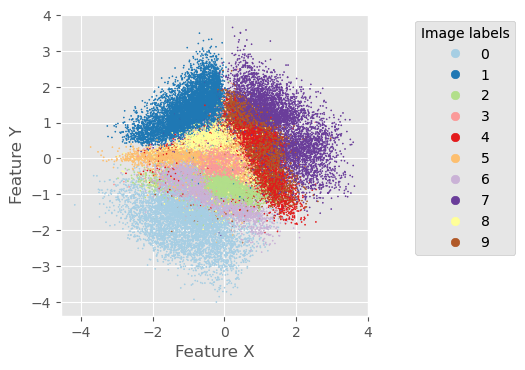

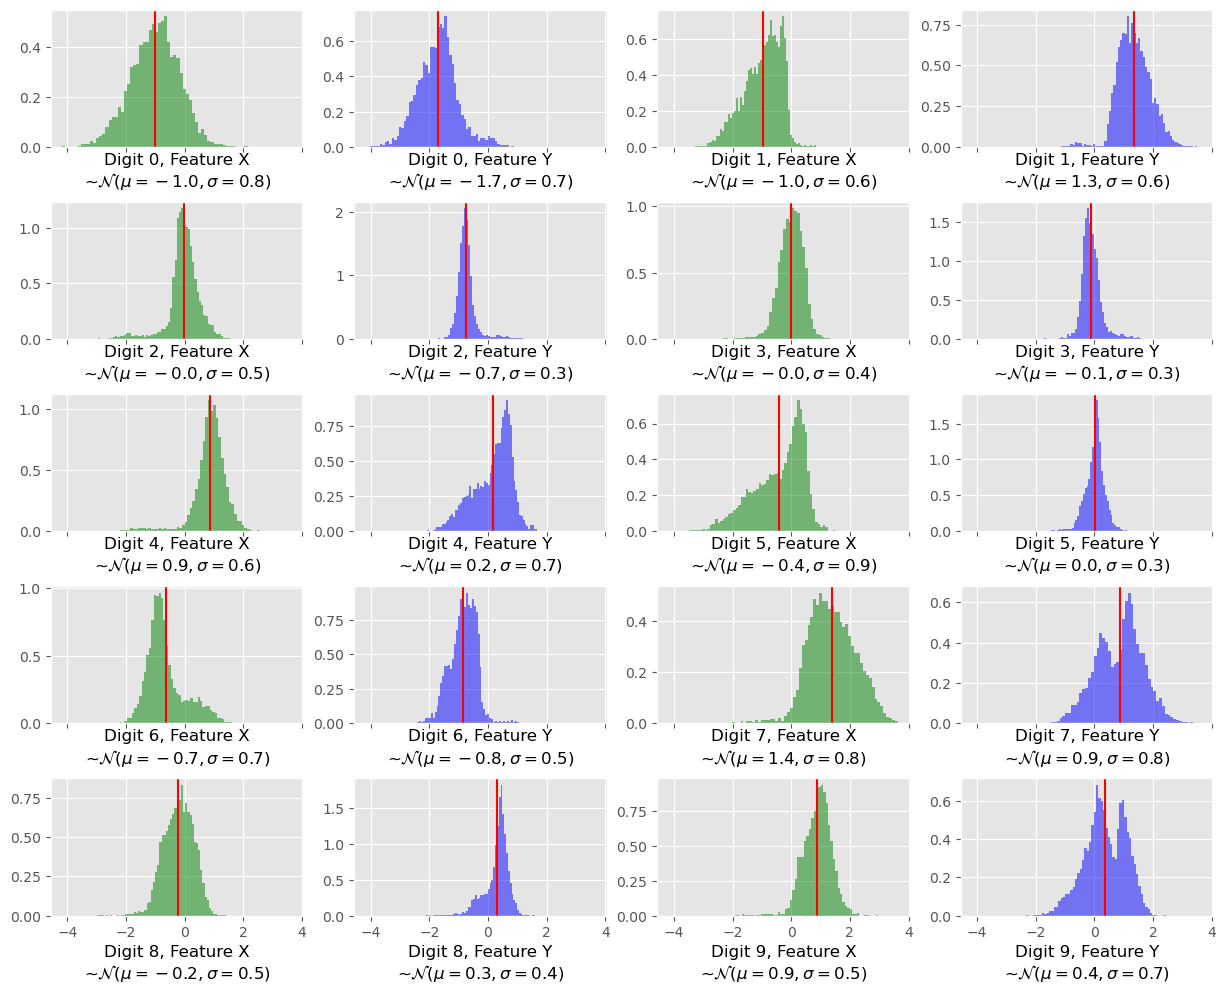

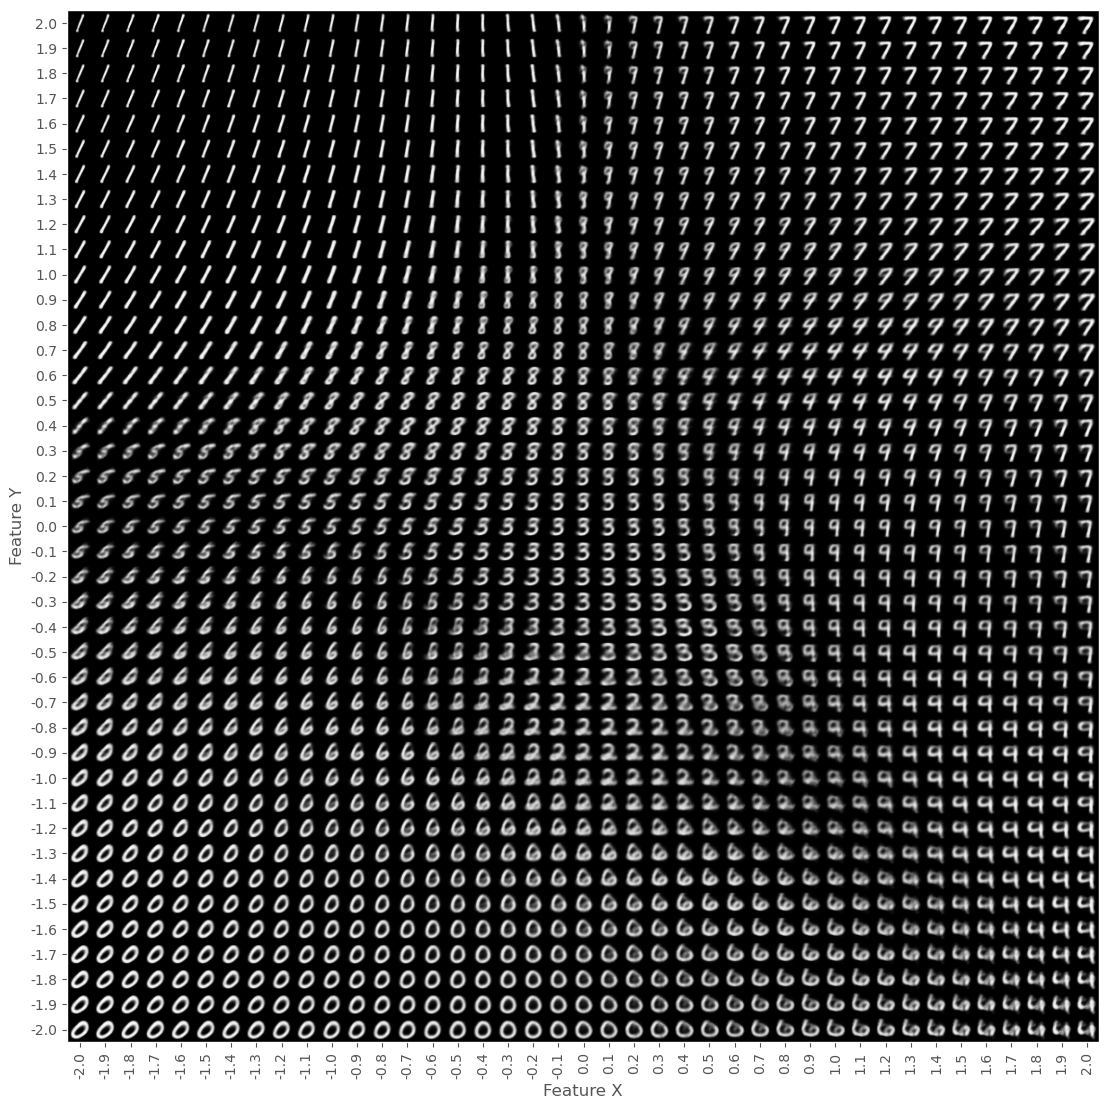

In [22]:
# encode images by BVAE
train_encodings_BVAE = encoder_BVAE.predict(train_images)

# scatter plot of encodings by BVAE
scatter_plot_encodings_latent(train_encodings_BVAE[2], train_labels)

# histogram plot of encodings by BVAE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_BVAE[2], train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_BVAE[2], train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

# generate images by BVAE
generate_images_latent(decoder_BVAE, x0=-2, x1=2, dx=.1, y0=-2, y1=2, dy=.1)

---

# Conditional Variational Autoencoders

In many applications, we hope to generate contents based on the labels. For example, we hope to generate images for a given digit from `mnist-digits`. Conditional VAEs serve this purpose. In a conditional VAE, the labels are sent to both the encoder and the decoder as an extra input, as shown in the following figure. 

<img src="https://i.ibb.co/pv1jCZH/cvaee.png" width=100% height=100% />


## 1. Implement a conditional VAE

The simplest way to implement a conditional VAE is to concatenate the labels to both the input data and the latent features. We will use this approach for our implementation. The one-hot encodings of the labels will be concatenated, which is a vector of size 10 (the condition dimension). 

### The encoder

The encoder is the same as that of the VAE except that

1. the input size is increased by the condition dimension; 
2. we no longer flatten the images inside the network because of the concatenation.

In [23]:
# dimension of condition
condition_dim = 10

# encoder
###############################################################
######## NEW: input size is increased by condition_dim ########
###############################################################
image_input = keras.Input(shape=(28 * 28 + condition_dim))
x = layers.Dense(128, activation='relu')(image_input)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_CVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_CVAE.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 794)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 128)          101760      input_8[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           2064        dense_16[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_17[0][0]                   
______________________________________________________________________________________

### The decoder

The same as the encoder, the input size of the decoder is increased by the condition dimension, and the reconstructed images will be flattened externally.

In [24]:
# decoder
###############################################################
######## NEW: input size is increased by condition_dim ########
###############################################################
z_input = keras.Input(shape=(latent_dim + condition_dim,))
x = layers.Dense(16, activation="relu")(z_input)
x = layers.Dense(128, activation="relu")(x)
image_output = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_CVAE = keras.Model(z_input, image_output)
decoder_CVAE.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                208       
_________________________________________________________________
dense_19 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_20 (Dense)             (None, 784)               101136    
Total params: 103,520
Trainable params: 103,520
Non-trainable params: 0
_________________________________________________________________


### The conditional VAE

The conditional VAE is the same as the VAE except that

1. the condition dimension is passed to the constructor;
2. the labels are concatenated to the latent features before they are decoded;
3. the labels are truncated from the input data to compute the reconstruction error.

In [25]:
# CVAE class
class CVAE(keras.Model):
    # constructor
    #################################################################
    ######## NEW: passing condition_dim as an extra argument ########
    #################################################################
    def __init__(self, encoder, decoder, condition_dim, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.condition_dim = condition_dim

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            ####################################################################
            ######## NEW: apply conditions to encodings before decoding ########
            ####################################################################
            z_cond = tf.concat([z, x[:, -self.condition_dim:]], axis=1)
            # decoding
            x_prime = self.decoder(z_cond)
            ###################################################################
            ######## NEW: truncate conditions for reconstruction error ########
            ###################################################################
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(x[:, :-self.condition_dim], x_prime)) * 28 * 28
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

# build the CVAE
cvae_model = CVAE(encoder_CVAE, decoder_CVAE, condition_dim)

# compile the CVAE
cvae_model.compile(optimizer=keras.optimizers.Adam())

Before training, we need to concatenate the images and their labels to generate the training data.

In [26]:
# one-hot encoding labels
train_labels_onehot = np.eye(10)[train_labels]

# flatten images
train_images_flattened = train_images.reshape((len(train_images), 28 * 28))

# concatenate labels to images
train_images_conditioned = np.concatenate((train_images_flattened, train_labels_onehot), axis=1)

# train the VAE
cvae_model.fit(train_images_conditioned, train_images_flattened, 
               epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 206.4286 - reconstruction_loss: 202.0724 - kl_loss: 4.3562
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 154.7305 - reconstruction_loss: 152.1894 - kl_loss: 2.5411
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 146.3395 - reconstruction_loss: 143.6297 - kl_loss: 2.7098
Epoch 4/50
469/469 [==============================] - 2s 3ms/step - loss: 142.2028 - reconstruction_loss: 139.4927 - kl_loss: 2.7101
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 139.7746 - reconstruction_loss: 137.0764 - kl_loss: 2.6982
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 138.1094 - reconstruction_loss: 135.4311 - kl_loss: 2.6783
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 136.8645 - reconstruction_loss: 134.1927 - kl_loss: 2.6718
Epoch 8/50
469/469 [==============================] - 2s 3ms/step - l

## 2. Evaluate the results

The latent distributions can be assessed in the same way. Note that *each digit now has its own latent distributions because of the conditioning* (all resemble a $\mathcal{N}(0,1)$), so the latent space is highly regular and disentangled. 

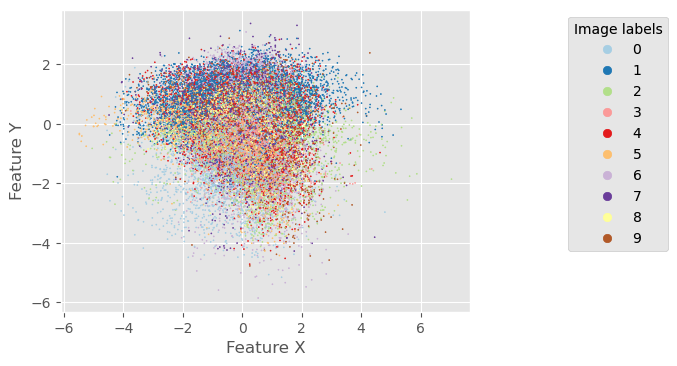

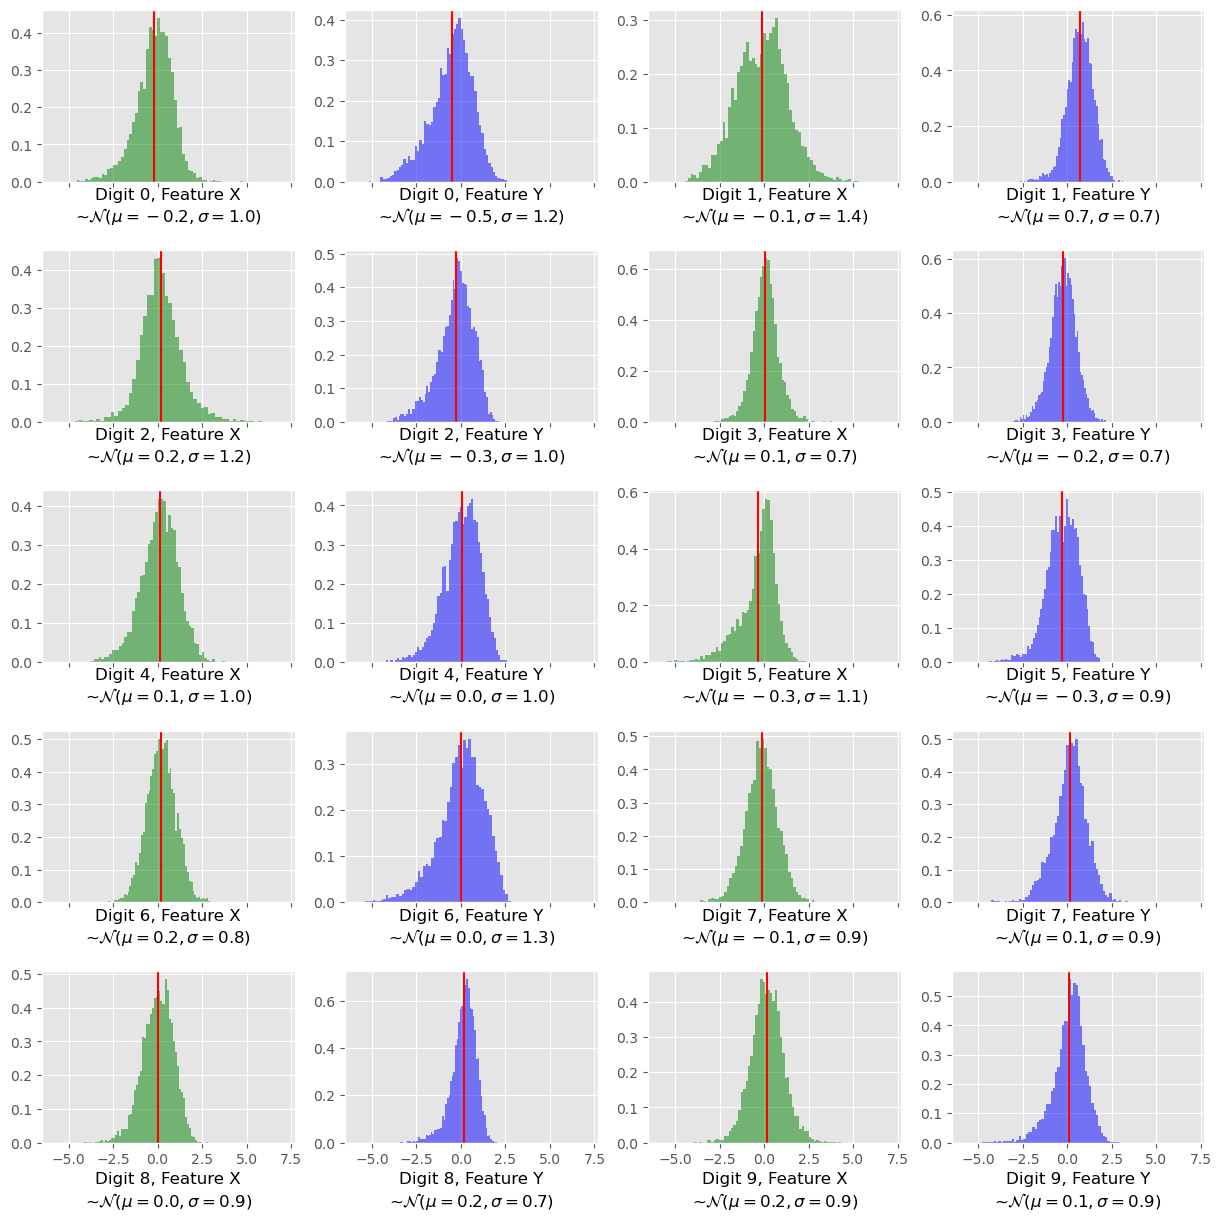

In [27]:
# encode images by CVAE
train_encodings_CVAE = encoder_CVAE.predict(train_images_conditioned)

# scatter plot of encodings by CVAE
scatter_plot_encodings_latent(train_encodings_CVAE[2], train_labels)

# histogram plot of xencodings by CVAE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 15), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_CVAE[2], train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_CVAE[2], train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

Finally, we can generate new images for each digit:

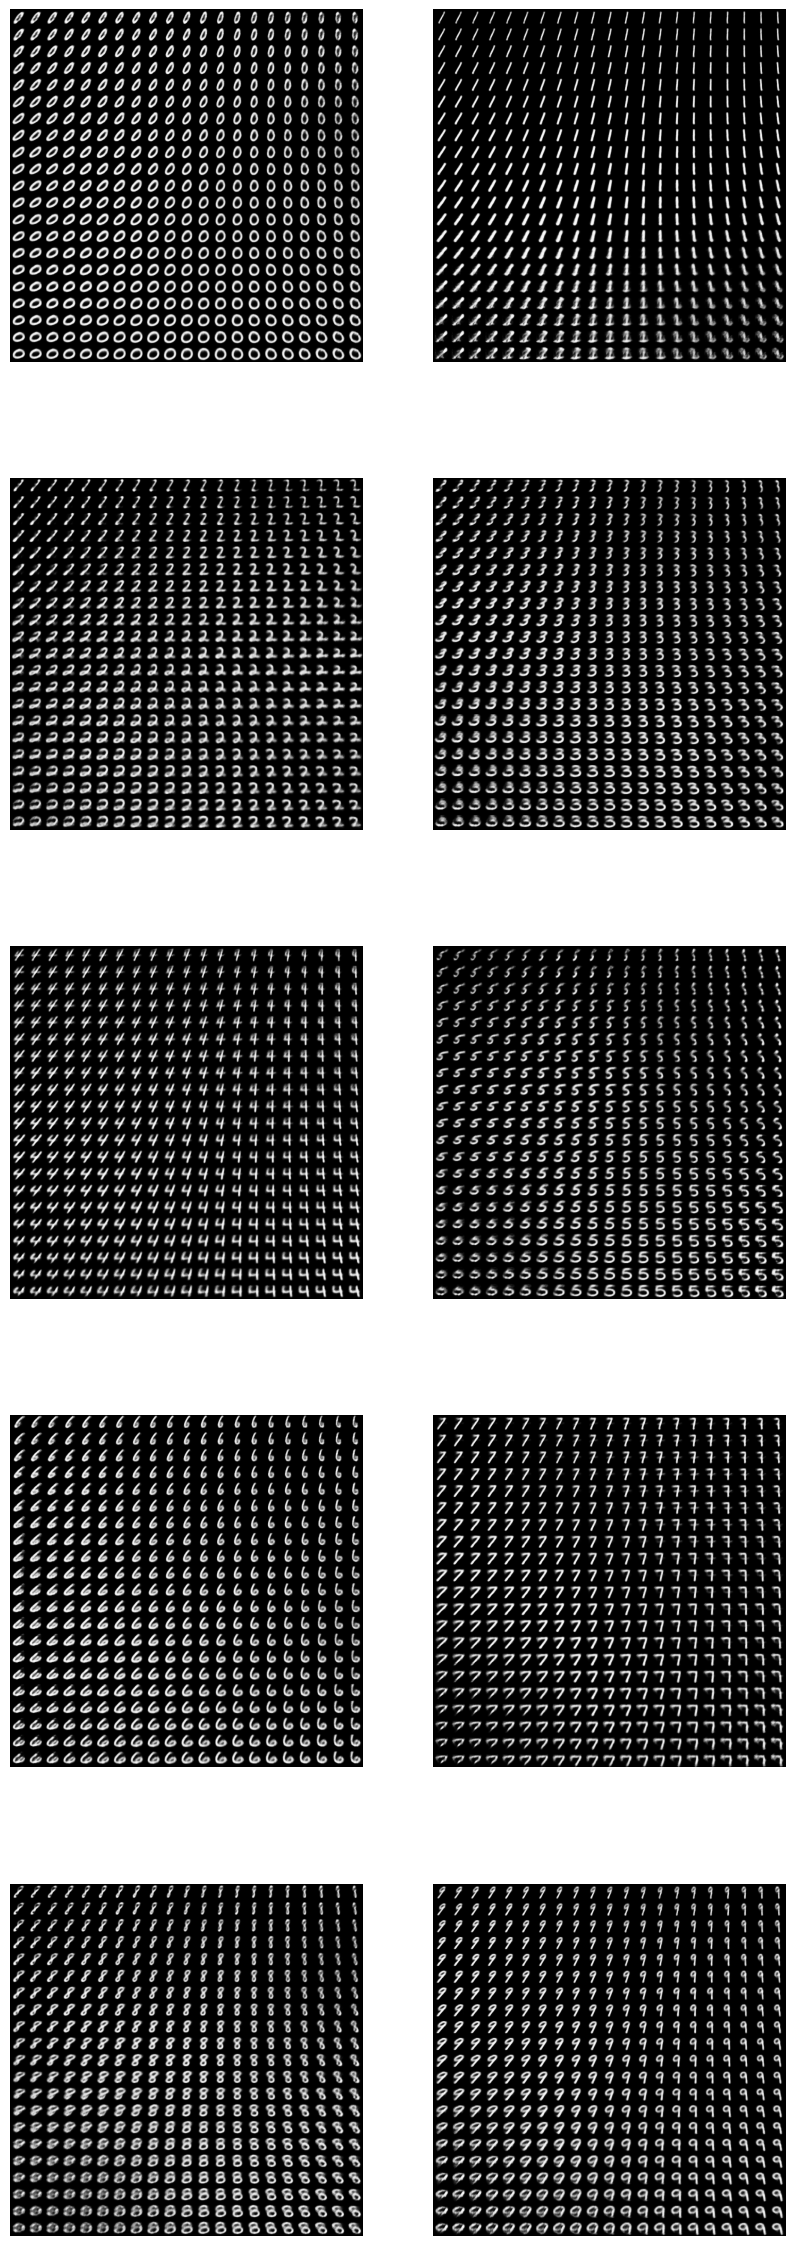

In [28]:
# generate images from the conditioned latent space
def generate_images_conditioned_latent(decoder, x0, x1, dx, y0, y1, dy, condition_digit, ax):
    # uniformly sample the latent space
    nx = round((x1 - x0) / dx) + 1
    ny = round((y1 - y0) / dy) + 1
    grid_x = np.linspace(x0, x1, nx)
    grid_y = np.linspace(y1, y0, ny)
    latent = np.array(np.meshgrid(grid_x, grid_y)).reshape(2, nx * ny).T
    
    # condition the latent space
    condiont_one_hot = np.eye(10)[condition_digit]
    latent = np.concatenate((latent, np.repeat([condiont_one_hot], len(latent), axis=0)), axis=1)

    # decode images
    decodings = decoder.predict(latent).reshape((len(latent), 28, 28))
    
    # display a (nx, ny) 2D manifold of digits
    figure = np.zeros((28 * ny, 28 * nx))
    for iy in np.arange(ny):
        for ix in np.arange(nx):
            figure[iy * 28 : (iy + 1) * 28, ix * 28 : (ix + 1) * 28] = decodings[iy * nx + ix]
            
    # plot figure
    ax.axis('off')
    ax.imshow(figure, cmap="Greys_r")
    
# generate images by CVAE
fig, axes = plt.subplots(5, 2, dpi=100, figsize=(10, 30), )
for digit in range(10):
    generate_images_conditioned_latent(decoder_CVAE, x0=-2, x1=2, dx=.2, y0=-2, y1=2, dy=.2,
                                        condition_digit=digit, ax=axes[digit // 2, digit % 2])
plt.show()

---

## Exercises

Use a VAE, $\beta$-VAE or conditional VAE to generate images from the `mnist-fashion` dataset. In this case, a latent dimension of two will be insufficient. For a larger latent dimension, you can use the above code for building and training the models without any changes. However, you have to generalise the code for plotting data distributions and generalising new images.